## Introduction
PyTorch is an open-source machine learning library for Python that provides a flexible and dynamic computational graph. It is widely used for deep learning and artificial intelligence research and development. It is one of the latest deep learning frameworks and was developed by the team at Facebook and open sourced on GitHub in 2017.

#### Why we use PyTorch
Simplicity and Ease of Use: PyTorch is known for its simplicity and ease of use, which makes it a popular choice among developers.
Dynamic Computational Graph: PyTorch uses dynamic computational graphs, which allows for flexibility in building and modifying models on the fly, which is beneficial for complex architectures.
Pythonic and Intuitive Syntax: PyTorch adopts a Pythonic programming style, making it easy to understand and use. Its syntax closely resembles standard Python code, which reduces the learning curve and simplifies rapid development.
#### Difference Between PyTorch and TensorFlow
PyTorch and TensorFlow are the two most popular deep learning libraries. They are both open source and have strong communities. However it can be said that they differ significantly at 2 different points.

 - Computational Graph: Pytorch uses a dynamic computational graph which means that the graph is built on the fly as operations are executed. This can make it more intuitive for debugging and experimentation. However TensorFlow uses a static computational graph. his means that the structure of the computational graph in TensorFlow is fixed when the graph is defined, whereas in PyTorch, the graph can be changed dynamically as the program runs.
 - API: Both PyTorch and TensorFlow offer useful abstractions that ease the development of models by reducing boilerplate code. However, they differ in their design philosophy, syntax, and features. PyTorch has a more “pythonic” approach and is object-oriented, while TensorFlow offers a variety of options. TensorFlow offers better visualization, which allows developers to debug better and track the training process. PyTorch, however, provides only limited visualization. TensorFlow excels in deploying trained models to production, thanks to the TensorFlow Serving framework. PyTorch does not offer such a framework, so developers need to use Django or Flask as a back-end server.
In conclusion, the choice between PyTorch and TensorFlow depends on the specific needs of your project. If you require a more pythonic approach and prefer a dynamic computational graph, PyTorch might be a better choice. If you need better visualization tools, production-ready deployment options, or a larger community and ecosystem, TensorFlow might be more suitable.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import math
import time

!unrar x "/content/drive/MyDrive/raw_data (1).rar"

raw_data_dir = "/content/raw_data"
print(os.listdir(raw_data_dir))

categories = os.listdir(raw_data_dir)
num_of_categories = len(categories)
print("Counts of Images = {}".format(num_of_categories))

os.mkdir("data")
os.mkdir("premolar")
os.mkdir("molar")
os.mkdir("incisor")
os.mkdir("canine")

for i in categories:
  if "premolar" in i:
    shutil.move("/content/raw_data/" + i, "/content/premolar")
  elif "molar" in i:
    shutil.move("/content/raw_data/" + i, "/content/molar")
  elif "incisor" in i:
    shutil.move("/content/raw_data/" + i, "/content/incisor")
  elif "canine" in i:
    shutil.move("/content/raw_data/" + i, "/content/canine")

print("Count of Premolar: {}".format(len(os.listdir("premolar"))))
print("Count of Molar: {}".format(len(os.listdir("molar"))))
print("Count of Incisor: {}".format(len(os.listdir("incisor"))))
print("Count of Canine: {}".format(len(os.listdir("canine"))))


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  raw_data/412_premolar5.jpg                                    57%  OK 
Extracting  raw_data/412_premolar6.jpg                                    57%  OK 
Extracting  raw_data/412_premolar7.jpg                                    57%  OK 
Extracting  raw_data/412_premolar8.jpg                                    57%  OK 
Extracting  raw_data/413_canine1.jpg                                      57%  OK 
Extracting  raw_data/413_canine2.jpg                                      57%  OK 
Extracting  raw_data/413_canine3.jpg                                      57%  OK 
Extracting  raw_data/413_canine4.jpg                                      57%  OK 
Extracting  raw_data/413_incisor1.jpg                                     57%  OK 
Extracting  raw_data/413_incisor2.jpg                                     57%  OK 
Extracting  raw_data/413_incisor3

#### Step by Step Coding
The dataset we will use will consist of 4 different classes. These are canine, molar, premolar and incisor respectively. Our expectation from the model we will create is to classify these teeth correctly. There are a total of 10876 images in our dataset. We will allocate 7613 of them for train. the rest will be divided into two and we will create the test and validation parts.

Importing the libraries we will use:

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, sampler, random_split
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import torch.nn.functional as F
import tqdm.notebook as tqdm
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2
import os
import shutil
import glob
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

4


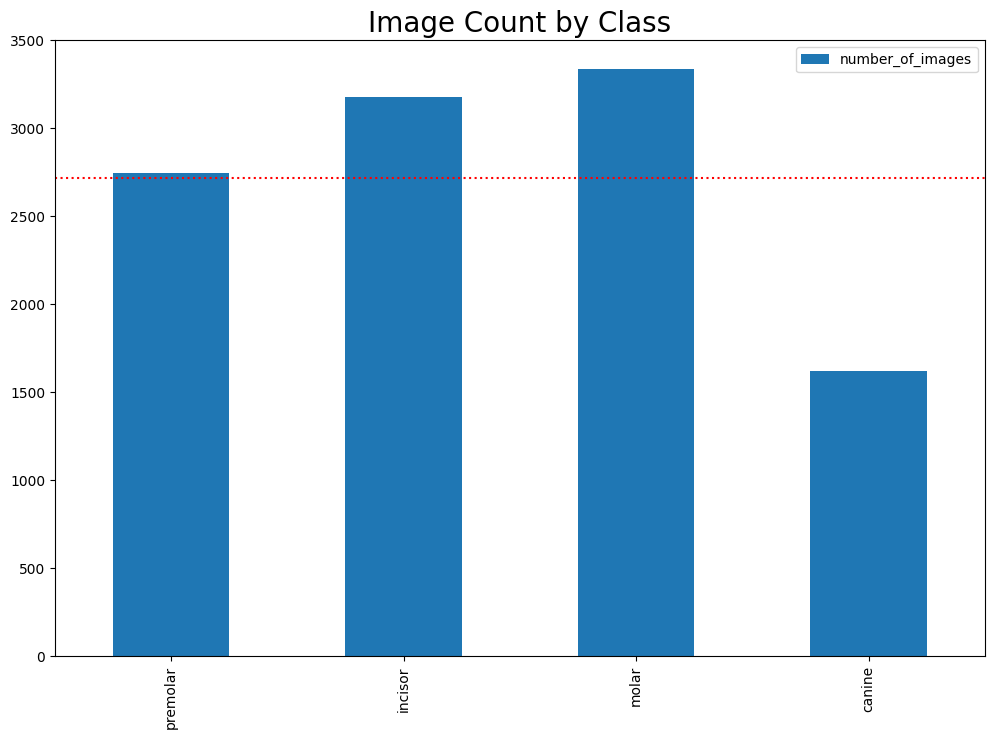

Mean Value of Image Numbers : 2719.0


In [ ]:
data_dir = "/content/data"
categories = os.listdir(data_dir)
num_of_categories = len(categories)
print(num_of_categories)

image_count_graph = pd.DataFrame(
    index = [i for i in categories],
    data = [len(os.listdir(data_dir + "/" + name))
              for name in categories],
    columns = ["number_of_images"]
)
image_count_graph


fig = image_count_graph.plot(kind = "bar", figsize = (12,8))
mean_of_pictures = image_count_graph["number_of_images"].mean()
fig.axhline(mean_of_pictures, color = "r", linestyle = ":", label = "Mean of Images")
plt.title("Image Count by Class", fontsize = 20)
plt.show()
print("Mean Value of Image Numbers :", mean_of_pictures)

Checking if CUDA(Compute Unified Device Architecture) is available for use with PyTorch. CUDA is a parallel computing platform and API model created by NVIDIA. It allows software developers to use a CUDA-enabled graphics processing unit (GPU) for general purpose processing.

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


Now it’s time for data transform. Here we will add more than one transformation. These are RandomResizedCrop, RandomRotation, ColorJitter, RandomHorizontalFlip, CenterCrop, ToTensor and Normalize. The reason we chose size 224 in CentreCrop is that we want it to comply with ImageNet standards. Likewise, Normalise values have been created accordingly. However, you can change the other transforms as you wish and observe the effect on the model success.

In [ ]:
img_transforms = {
    "train":
    transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale = (0.8, 1.0)),
        transforms.RandomRotation(degrees = 15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test":
    transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

Now we need to split image dataset training, validation, and testing sets, apply transformations to those sets, and then load them into PyTorch DataLoaders for use in training a model. Each stage is described with a comment line.

In [ ]:
#Loading data from the directory and applying the transform.
data = datasets.ImageFolder(root = "/content/data", transform = img_transforms["train"])

#Calculating the lengths of the training, validation and test sets.
#Splitting the dataset into 70% training, 15% validation, and 15% test data.
train_data_len = int(len(data)*0.7)
valid_data_len = int((len(data) - train_data_len)/2)
test_data_len = int(len(data) - train_data_len - valid_data_len)

print("Train Data Length :", train_data_len)
print("Validation Data Length :", valid_data_len)
print("Test Data Length :", test_data_len)

#Creating train, validation and test data randomly.
train_data, val_data, test_data = random_split(data, [train_data_len, valid_data_len, test_data_len])

#Applying the specified transformations to the training, validation, and test datasets.
train_data.dataset.transform = img_transforms['train']
val_data.dataset.transform = img_transforms['test']
test_data.dataset.transform = img_transforms['test']

print("Length of train data: ", len(train_data), "\n",
      "Length of val data:",  len(val_data), "\n",
      "Length of test data:", len(test_data))

#Creating data loaders for the training, validation, and test datasets. The DataLoader class from torch.utils.data is used to load the data in batches of size batch, and the data is shuffled for each epoch during training.
batch = 32
train_loader = DataLoader(dataset = train_data, batch_size=batch, shuffle=True)
val_loader = DataLoader(dataset = val_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch, shuffle=True)

#Creating dictionaries for the data loaders and the sizes of the training and validation datasets.
dataloaders = {"train":train_loader, "val":val_loader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

#An iterator for the training data loader and get the first batch of features and labels.
trainiter = iter(train_loader)
features, labels = next(trainiter)

print(features.shape, labels.shape)
print(data_sizes)

Train Data Length : 7613
Validation Data Length : 1631
Test Data Length : 1632
Length of train data:  7613 
 Length of val data: 1631 
 Length of test data: 1632
torch.Size([32, 3, 224, 224]) torch.Size([32])
{'train': 7613, 'val': 1631}


#### Basic CNN
First, we will use a CNN model that we will create from scratch in the classification task and analyse the results. In the comment lines of the code, the new shape after each operation is explained. In addition, let’s look at what we do in each layer one by one.

 - Convolutional Layer 1 (conv1): This layer takes an input with 3 channels (corresponding to the RGB color channels of the input image) and applies a convolution operation with 12 filters, each of size 3x3. The stride is 1 and padding is 1, which means the convolution operation will be applied to all pixels in the input, and the output will have the same width and height as the input.
 - Batch Normalization Layer 1 (bn1): This layer normalizes the output from the first convolutional layer. It helps in improving the performance of the network by reducing the internal covariate shift, which is a change in the distribution of layer inputs.
 - ReLU Activation Layer 1 (relu1): This layer applies the Rectified Linear Unit (ReLU) activation function to the output from the batch normalization layer. The ReLU function helps to introduce non-linearity into the network.
 - Max Pooling Layer (pool): This layer reduces the spatial dimensions (width and height) of the input by taking the maximum value over a 2x2 window. This helps to reduce the number of parameters in the network and control overfitting.
 - Convolutional Layer 2 (conv2): This layer applies a convolution operation with 20 filters, each of size 3x3, to the output from the max pooling layer. The stride is 1 and padding is 1.
 - ReLU Activation Layer 2 (relu2): This layer applies the ReLU activation function to the output from the second convolutional layer.
 - Convolutional Layer 3 (conv3): This layer applies a convolution operation with 32 filters, each of size 3x3, to the output from the ReLU activation layer of the second convolutional layer.
 - Batch Normalization Layer 3 (bn3): This layer normalizes the output from the third convolutional layer.
 - ReLU Activation Layer 3 (relu3): This layer applies the ReLU activation function to the output from the batch normalization layer of the third convolutional layer.
 - Fully Connected Layer 1 (fc1): This layer flattens the output from the ReLU activation layer of the third convolutional layer into a 1D tensor and applies a linear transformation. It has 120 output features.
 - Fully Connected Layer 2 (fc2): This layer applies a linear transformation to the output from the first fully connected layer. The number of output features is equal to the number of classes in the classification task.
The forward function defines the sequence in which these layers are applied to the input. The output of each layer is passed as the input to the next layer. The output of the second fully connected layer is the final output of the network.

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_classes = 4):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size=3, stride = 1, padding = 1)
    #Shape = (32, 12, 224, 224)
    self.bn1 = nn.BatchNorm2d(num_features = 12)
    #Shape = (32, 12, 224, 224)
    self.relu1 = nn.ReLU()
    #Shape = (32, 12, 224, 224)
    self.pool = nn.MaxPool2d(kernel_size = 2)
    #Reduce the image size be factor 2
    #Shape = (32, 12, 112, 112)
    self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 20, kernel_size = 3, stride = 1, padding = 1)
    #Shape = (32, 20, 112, 112)
    self.relu2 = nn.ReLU()
    #Shape = (32, 20, 112, 112)
    self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.relu3 = nn.ReLU()
    #Shape = (32, 32, 112, 112)
    self.fc1 = nn.Linear(in_features = 112*112*32, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = num_classes)

  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)
    output = self.pool(output)
    output = self.conv2(output)
    output = self.relu2(output)
    output = self.conv3(output)
    output = self.bn3(output)
    output = self.relu3(output)
    #Above output will be in matrix form, with shape (32,32,112, 112)
    output = output.view(-1, 112*112*32)
    output = F.relu(self.fc1(output))
    output = self.fc2(output)
    return output



Let’s define the model and create the hyperparameters. These created hyperparameters will be exactly the same in the models we will use in the future.

In [ ]:
model = ConvNet(num_classes = 4).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs = 8

In [ ]:
train_count = train_data_len
test_count = test_data_len

print(train_count, test_count)

7613 1632


Model training and saving the best model

In [ ]:
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / test_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 0 Train Loss: tensor(4.7534) Train Accuracy: 0.44489688690398005 Test Accuracy: 0.4944852941176471
Epoch: 1 Train Loss: tensor(1.0115) Train Accuracy: 0.5326415342177854 Test Accuracy: 0.5116421568627451
Epoch: 2 Train Loss: tensor(0.9451) Train Accuracy: 0.5640352029423354 Test Accuracy: 0.5306372549019608
Epoch: 3 Train Loss: tensor(0.9299) Train Accuracy: 0.5883357414948115 Test Accuracy: 0.59375
Epoch: 4 Train Loss: tensor(0.9170) Train Accuracy: 0.5970051228162354 Test Accuracy: 0.48713235294117646
Epoch: 5 Train Loss: tensor(0.8904) Train Accuracy: 0.608038880861684 Test Accuracy: 0.5526960784313726
Epoch: 6 Train Loss: tensor(0.8323) Train Accuracy: 0.6341783790884015 Test Accuracy: 0.6170343137254902
Epoch: 7 Train Loss: tensor(0.8094) Train Accuracy: 0.6582162091159858 Test Accuracy: 0.6200980392156863


The CNN model we created obtained 0.62 as the highest validation accuracy after 8 epochs. Not a bad result considering that it is a very basic model. Now let’s try the well-known and frequently used Xception model both with and without transfer learning and see the results.

### Xception with Transfer Learning

In [ ]:
!pip install timm
import torch
from torch.autograd import Variable
import timm

# Assuming train_loader and test_loader are defined

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and move it to the appropriate device
model = timm.create_model('xception', pretrained=True)
model = model.to(device)

# Define loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / test_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch: 0 Train Loss: tensor(0.7809) Train Accuracy: 0.7271771969000395 Test Accuracy: 0.8075980392156863
Epoch: 1 Train Loss: tensor(0.4320) Train Accuracy: 0.836201234730067 Test Accuracy: 0.8327205882352942
Epoch: 2 Train Loss: tensor(0.3314) Train Accuracy: 0.8787600157625115 Test Accuracy: 0.8382352941176471
Epoch: 3 Train Loss: tensor(0.2262) Train Accuracy: 0.918429003021148 Test Accuracy: 0.8363970588235294
Epoch: 4 Train Loss: tensor(0.1818) Train Accuracy: 0.9345855773019834 Test Accuracy: 0.8694852941176471
Epoch: 5 Train Loss: tensor(0.1617) Train Accuracy: 0.9399711020622619 Test Accuracy: 0.8498774509803921
Epoch: 6 Train Loss: tensor(0.1182) Train Accuracy: 0.9612504925784842 Test Accuracy: 0.8462009803921569
Epoch: 7 Train Loss: tensor(0.1193) Train Accuracy: 0.956390384867989 Test Accuracy: 0.8449754901960784


By saying pretrained = True, we also include transfer learning. Again, we use the same hyperparameters and train the model using the same code we wrote for training above. The highest validation accuracy for this model is 0.87. Now let’s try it without transfer learning.

### Xception without Transfer Learning

In [ ]:
#!pip install timm
import torch
from torch.autograd import Variable
import timm

# Assuming train_loader and test_loader are defined

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and move it to the appropriate device
model = timm.create_model('xception', pretrained=False)
model = model.to(device)

# Define loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / test_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 0 Train Loss: tensor(1.0723) Train Accuracy: 0.5624589517929857 Test Accuracy: 0.6421568627450981
Epoch: 1 Train Loss: tensor(0.8644) Train Accuracy: 0.6326021279390516 Test Accuracy: 0.6580882352941176
Epoch: 2 Train Loss: tensor(0.7846) Train Accuracy: 0.6689872586365427 Test Accuracy: 0.6868872549019608
Epoch: 3 Train Loss: tensor(0.7093) Train Accuracy: 0.7083935373702877 Test Accuracy: 0.7340686274509803
Epoch: 4 Train Loss: tensor(0.6504) Train Accuracy: 0.7351898069092342 Test Accuracy: 0.7555147058823529
Epoch: 5 Train Loss: tensor(0.5793) Train Accuracy: 0.7626428477604098 Test Accuracy: 0.7763480392156863
Epoch: 6 Train Loss: tensor(0.5243) Train Accuracy: 0.7952187048469723 Test Accuracy: 0.7591911764705882
Epoch: 7 Train Loss: tensor(0.4592) Train Accuracy: 0.8184684092998817 Test Accuracy: 0.772671568627451


At this point, we can clearly see the effect of transfer learning. The highest validation accuracy dropped from 0.87 to 0.77. Let’s apply the same thing we applied to Xception for ResNet50 and take a look at the results.

### ResNet50 with Transfer Learning

In [ ]:
model = models.resnet50(pretrained = True)
model = model.to(device)

# Define loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / test_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


Epoch: 0 Train Loss: tensor(1.0100) Train Accuracy: 0.6097464862734796 Test Accuracy: 0.6158088235294118
Epoch: 1 Train Loss: tensor(0.7474) Train Accuracy: 0.693813214238802 Test Accuracy: 0.6850490196078431
Epoch: 2 Train Loss: tensor(0.6487) Train Accuracy: 0.7370287665834756 Test Accuracy: 0.7800245098039216
Epoch: 3 Train Loss: tensor(0.5821) Train Accuracy: 0.7730198344936293 Test Accuracy: 0.7610294117647058
Epoch: 4 Train Loss: tensor(0.5257) Train Accuracy: 0.7977144358334428 Test Accuracy: 0.7953431372549019
Epoch: 5 Train Loss: tensor(0.4701) Train Accuracy: 0.8204387232365691 Test Accuracy: 0.7824754901960784
Epoch: 6 Train Loss: tensor(0.4413) Train Accuracy: 0.8314724812820176 Test Accuracy: 0.7996323529411765
Epoch: 7 Train Loss: tensor(0.3764) Train Accuracy: 0.8615526073821096 Test Accuracy: 0.8345588235294118


The highest validation accuracy obtained using the same hyperparameters was 0.83. The model performed lower than Xception with transfer learning. Finally, let’s train without transfer learning and look at the results.

In [ ]:
model = models.resnet50(pretrained = False)
model = model.to(device)

# Define loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / test_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0 Train Loss: tensor(1.1364) Train Accuracy: 0.5280441350321818 Test Accuracy: 0.5729166666666666
Epoch: 1 Train Loss: tensor(0.9858) Train Accuracy: 0.5804544857480626 Test Accuracy: 0.4497549019607843
Epoch: 2 Train Loss: tensor(0.9554) Train Accuracy: 0.5909628267437278 Test Accuracy: 0.5447303921568627
Epoch: 3 Train Loss: tensor(0.9006) Train Accuracy: 0.6213056613687115 Test Accuracy: 0.539828431372549
Epoch: 4 Train Loss: tensor(0.8761) Train Accuracy: 0.630894522527256 Test Accuracy: 0.6550245098039216
Epoch: 5 Train Loss: tensor(0.8488) Train Accuracy: 0.6457375541836332 Test Accuracy: 0.6139705882352942
Epoch: 6 Train Loss: tensor(0.7898) Train Accuracy: 0.6655720478129515 Test Accuracy: 0.5949754901960784
Epoch: 7 Train Loss: tensor(0.7513) Train Accuracy: 0.6789701825824248 Test Accuracy: 0.6887254901960784


ResNet50 performed very badly without Transfer Learning. The highest validation accuracy obtained was 0.68.

We can say that Xception and Resnet models show a very successful performance when transfer learning is applied. Without any fine tuning or any work to increase performance, it is a result that can be called quite sufficient that both of them see above 85%. In addition, it is also noteworthy that the basic cnn model is successful than the transfer learning resnet model. The reasons for this can be listed as follows:

 - Dataset Suitability: Large and complex models such as ResNet50 usually perform better on a large and diverse dataset. However, sometimes a simple model can give better results on a smaller dataset.
 - Hyperparameters: The best model architecture for each problem may differ, so building a specific model for a specific problem can sometimes give better results.
 - Overfitting: Complex models, such as ResNet-50, usually include more parameters, which can increase the risk of overfitting. The simple model can have fewer parameters, which can reduce the risk of overfitting.

